In [1]:
import numpy as np
from pathlib import Path
import time
import matplotlib.pyplot as plt
start_time = time.time()

import xobjects as xo
import xtrack as xt
import xpart as xp
import xobjects as xo
import xcoll as xc

#import apertls
from matplotlib.colors import LogNorm

In [2]:
# This script takes around 8 minutes on a modern CPU (80s preparation+interpolation, 400s tracking)
context = xo.ContextCpu()

beam = 1
plane = 'DNeg'#'DPpos'

num_particles  = 500
sweep          = 3500
sweep          = -abs(sweep) if plane == 'DPpos' else abs(sweep)
#num_turns      = int(20*abs(sweep))
num_turns=6000

In [3]:
nemitt_x = 3.5e-6
nemitt_y = 3.5e-6

In [4]:
line = xt.Line.from_json('../injection_lines/sps_with_aperture_inj_q20_beam_sagitta2.json')

Loading line from dict:   0%|          | 0/36395 [00:00<?, ?it/s]

Done loading line from dict.           


In [5]:
#hanging voltage, frequency and phase
V200 = line['actcse.31632'].voltage/20
phi200 = line['actcse.31632'].lag
f200 = line['actcse.31632'].frequency

V800 = line['acl.31735'].voltage/2
phi800 = line['acl.31735'].lag
f800 = line['acl.31735'].frequency

for cav in line.get_elements_of_type(xt.Cavity)[1]:
    if 'actcs' in cav:
        line[cav].frequency = f200
        line[cav].lag = phi200
        line[cav].voltage = V200
    elif 'acl' in cav:
        line[cav].frequency = f800
        line[cav].lag = phi800
        line[cav].voltage = V800

In [6]:
line.build_tracker()
line.discard_tracker()

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [7]:
theta = np.atan(5.3/809)
L1 = 34e-3
L2 = 21e-3
L3 = 754e-3
h_tot = 5.3e-3

x1 = L1/np.cos(theta)
x2 = L2/np.cos(theta)
x3 = L3/np.cos(theta)

print(np.sin(theta)*(x1+x2+x3), h_tot)

x_tot = x1+x2+x3
w_steel = x1/x_tot
w_air = (x2+x3)/x_tot

print(w_steel, w_air)

0.0053 0.0053
0.04202719406674908 0.9579728059332508


In [8]:
d_steel_air = x2+x3

X_Be = 35.28e-2
X_air = 303.9
X_Fe = 1.757e-2
X_C = 19.32e-2
X_steel = (0.02/X_C + 0.98/X_Fe)**(-1)
X_steel_air = (w_steel/X_steel + w_air/X_air)**(-1)

d_Be = X_Be/X_steel_air * d_steel_air #shorter than d_steel_air so we can keep angle theta and stop collimator before end of VCAK

In [9]:
line.discard_tracker()
#collimator jaw positions:
ap_vebb_x = 0.0645
jaw_ru = -ap_vebb_x
jaw_rd = -ap_vebb_x - h_tot
jaw_lu = ap_vebb_x
jaw_ld = ap_vebb_x - h_tot
L_coll = d_Be

coll_12501 = xc.EverestCollimator(length=L_coll, material=xc.materials.Beryllium, jaw_RU=jaw_ru, jaw_RD=jaw_rd, jaw_LU=jaw_lu, jaw_LD=jaw_ld)
coll_61101 = xc.EverestCollimator(length=L_coll, material=xc.materials.Beryllium, jaw_RU=jaw_ru, jaw_RD=jaw_rd, jaw_LU=jaw_lu, jaw_LD=jaw_ld)
name_colls = ['vcak.12501_coll', 'vcak.61101_coll']
s_colls = [line.get_s_position('vebb.12490.b_aper'), line.get_s_position('vebb.61090.b_aper')]

names_vcak_apers_to_remove = ['vcak.12501.a_aper', 'vcak.12501.b_aper', 'vcak.61101.a_aper', 'vcak.61101.b_aper']
# for name in names_vcak_apers_to_remove:
#     line.remove(name)

line.collimators.install(names=name_colls, elements=[coll_12501, coll_61101], at_s=s_colls)

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Slicing line:   0%|          | 0/75252 [00:00<?, ?it/s]

In [10]:
#optics
tw = line.twiss()
line.collimators.assign_optics(nemitt_x=nemitt_x, nemitt_y=nemitt_y)

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [11]:
#particles
part = xp.generate_matched_gaussian_bunch(nemitt_x=nemitt_x,
                                          nemitt_y=nemitt_y,
                                          sigma_z=0.224, num_particles=num_particles, line=line)
line.discard_tracker()
line.build_tracker(_context=xo.ContextCpu(omp_num_threads='25'))

*** Maximum RMS bunch length 0.23336637795139523m.
... distance to target bunch length: -2.2228e-01
... distance to target bunch length: 4.5424e-03
... distance to target bunch length: 4.3382e-03
... distance to target bunch length: -6.6565e-03
... distance to target bunch length: 2.0203e-03
... distance to target bunch length: -5.7185e-04
... distance to target bunch length: 1.0779e-04
... distance to target bunch length: 4.7891e-06
... distance to target bunch length: -2.0504e-09
... distance to target bunch length: 9.6490e-08
--> Bunch length: 0.22399999794961284
--> Emittance: 0.3436704481089558
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [12]:
#rf sweep
rf_sweep = xc.RFSweep(line)
rf_sweep.info(sweep=sweep, num_turns=num_turns)

Cannot sweep multiple cavities with different frequencies! Choosing lowest non-zero frequency to sweep...
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
The current frequency is 200000000.0Hz, adding 0.5833333333333334Hz per turn until 200003500.0 (for 6000 turns).
This sweep will move the center of the bucket with Δδ = -0.00975018488235657 (-1.335753318770423 buckets).


In [13]:
#tracking
line.scattering.enable()
rf_sweep.track(sweep=sweep, particles=part, num_turns=num_turns, time=True, with_progress=5)
line.scattering.disable()
print(f"Done sweeping RF in {line.time_last_track:.1f}s.")

Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

All particles lost at turn 5887, stopped sweep at 2747.499608Hz.
Done sweeping RF in 5535.3s.


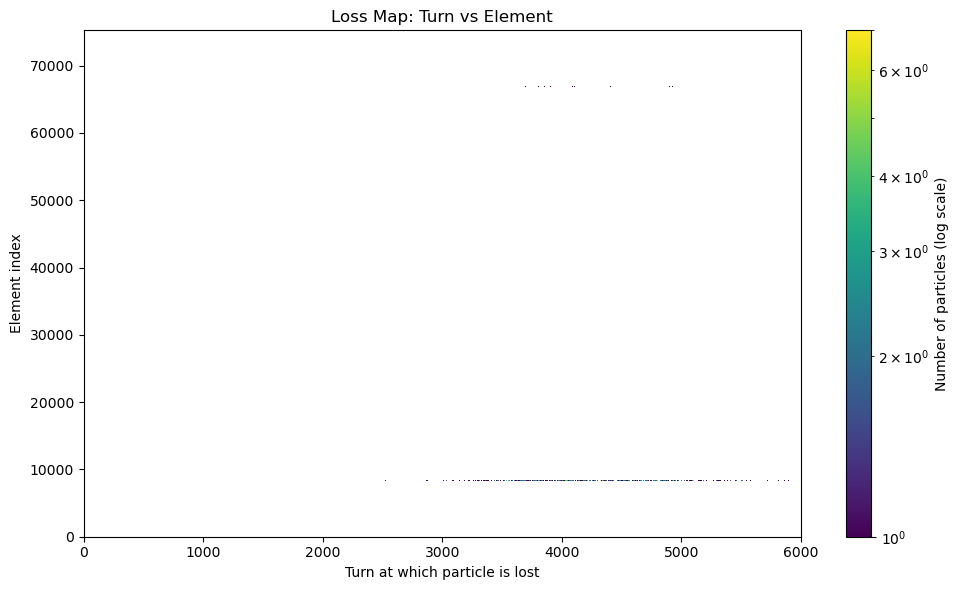

In [16]:
#Plot
turn_bins_resolution = 1000
turn_min, turn_max = 0, num_turns
turn_bins = np.linspace(turn_min, turn_max, turn_bins_resolution + 1)

element_bin_resolution = 1000
element_min, element_max = 0, len(line.element_names)
element_bins = np.linspace(element_min, element_max, element_bin_resolution + 1)

hist2d, element_edges, turn_edges = np.histogram2d(
    part.at_element[part.state<=0], part.at_turn[part.state<=0],
    bins=[element_bins, turn_bins]
)

plt.figure(figsize=(10, 6))
plt.imshow(hist2d, aspect='auto', interpolation='nearest',
           extent=[turn_bins[0], turn_bins[-1], element_bins[0], element_bins[-1]],
           origin='lower', norm=LogNorm())

plt.colorbar(label='Number of particles (log scale)')
plt.xlabel('Turn at which particle is lost')
plt.ylabel('Element index')
plt.title('Loss Map: Turn vs Element')

plt.tight_layout()
plt.show()

In [17]:
np.unique(part.at_element, return_counts=True)

(array([ 8391, 66875]), array([489,  11]))